In [1]:
!ls

'=3.0.0'				  preprocess_data
 advanced-segmentation-structure	  pretrain_result
 bk-isut-dataset			  pretrain_weights
 crop_output				  __pycache__
 eval.ipynb				  result
 eval_pspnet.ipynb			  save_data_path
 fine_tune_model.py			  SegFormer
 get_pretrain_weight.py			  show_light_weight_improment.ipynb
 global-land-cover-mapping-openearthmap   smooth_tiled_predictions.py
 inference.ipynb			  train_baseline.py
 infer_image				  train_segformer.py
 infer_light_weight_model.ipynb		  train_upernet.py
 offline_distill_train.py		  Upernet
 plot_prediction.ipynb			  weights


In [2]:
import os

In [3]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [4]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from smooth_tiled_predictions import predict_img_with_smooth_windowing

2024-07-03 19:16:02.364385: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 19:16:02.382846: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 19:16:02.382865: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 19:16:02.382877: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-03 19:16:02.386481: I tensorflow/core/platform/cpu_feature_g

Segmentation Models: using `tf.keras` framework.


In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [6]:
img = cv2.imread("infer_image/original.tif", 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = plt.imread("infer_image/mask.tif")

In [7]:
# # Use this code to infer a smaller patch of a large image
# width = 2560
# height = 2560
# # Calculate the coordinates for the top right quarter
# start_row, start_col = height // 10 * 4, width // 10 * 4 
# end_row, end_col = height // 10 * 6, width // 10 * 6

# # Extract the top right quarter of the image
# img = img[start_row:end_row, start_col:end_col]

# # Extract the top right quarter of the mask
# mask = mask[start_row:end_row, start_col:end_col]

# plt.imshow(img)
# plt.show()


In [8]:
from Upernet.models import upernet_convnext_tiny_org

In [9]:
checkpoint_path = "./weights/augmented_upernet_tiny_org_with_pretrain_converge/cp.weights.h5"
model = upernet_convnext_tiny_org.UPerNet(input_shape = (256, 256,3), num_classes = 5)
model.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score],)
model.load_weights(checkpoint_path)

2024-07-03 19:16:03.376845: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-03 19:16:03.376861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: ngoc-Z790-D-DDR4
2024-07-03 19:16:03.376864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: ngoc-Z790-D-DDR4
2024-07-03 19:16:03.376905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2024-07-03 19:16:03.376912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2024-07-03 19:16:03.376914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'convnext_tiny_stage_0_block_2_layernorm')>, <KerasTensor: shape=(None, 32, 32, 192) dtype=float32 (created by layer 'convnext_tiny_stage_1_block_2_layernorm')>, <KerasTensor: shape=(None, 16, 16, 384) dtype=float32 (created by layer 'convnext_tiny_stage_2_block_8_layernorm')>, <KerasTensor: shape=(None, 8, 8, 768) dtype=float32 (created by layer 'convnext_tiny_stage_3_block_2_layernorm')>]


In [10]:
# model.summary()

In [11]:
# size of patches
patch_size = 256

# Number of classes 
n_classes = 5

In [12]:
large_img = Image.fromarray(img)
large_img = np.array(large_img)     
print(large_img.shape)

(2560, 2560, 3)


In [13]:
import time

In [14]:
# Start the timer
start_time = time.time()

# Predict patch by patch with no smooth blending
SIZE_X = (img.shape[1] // patch_size) * patch_size  # Nearest size divisible by our patch size
SIZE_Y = (img.shape[0] // patch_size) * patch_size  # Nearest size divisible by our patch size

large_img = Image.fromarray(img)
large_img = large_img.crop((0, 0, SIZE_X, SIZE_Y))  # Crop from top left corner
large_img = np.array(large_img)
print(large_img.shape)

patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)  # Step=256 for 256 patches means no overlap
patches_img = patches_img[:, :, 0, :, :, :]
print(patches_img.shape)

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :, :]
        
        # Use MinMaxScaler instead of just dividing by 255.
        # single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        pred = model.predict(single_patch_img)
        pred = np.argmax(pred, axis=3)
        pred = pred[0, :, :]
        
        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
print(patched_prediction.shape)  # Should be (number_of_patches, patch_height, patch_width)

# Reshape to 4D array
patched_prediction = patched_prediction.reshape((patches_img.shape[0], patches_img.shape[1], patch_size, patch_size))

# Unpatchify to get the large image
unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0], large_img.shape[1]))

# End the timer
end_time = time.time()

# Calculate and print the total time taken
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

(2560, 2560, 3)
(10, 10, 256, 256, 3)


2024-07-03 19:16:05.121137: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x77d4a0028260 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-07-03 19:16:05.121157: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-07-03 19:16:05.125702: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-07-03 19:16:05.125779: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


1/1 [==============================] - 0s 320ms/step
(100, 256, 256)
Total time taken: 34.38 seconds


In [15]:
# Smooth blending
# predictions_smooth = predict_img_with_smooth_windowing(
#     img,
#     window_size=patch_size,
#     subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
#     nb_classes=n_classes,
#     pred_func=(
#         lambda img_batch_subdiv: model.predict((img_batch_subdiv))
#     )
# )


# final_prediction = np.argmax(predictions_smooth, axis=2)

In [22]:
# plt.figure(figsize=(20, 5))
# plt.subplot(141)
# plt.title('Image')
# plt.imshow(img)
# plt.subplot(142)
# plt.title('Ground Truth')
# plt.imshow(mask, vmin=0, vmax=4)
# plt.subplot(143)
# plt.title('Prediction')
# plt.imshow(unpatched_prediction, vmin=0, vmax=4)

# plt.subplot(144)
# plt.title('Error')
# error = (mask != unpatched_prediction)
# error = error.astype('float32')
# plt.imshow(error, cmap='gray')
# plt.show()

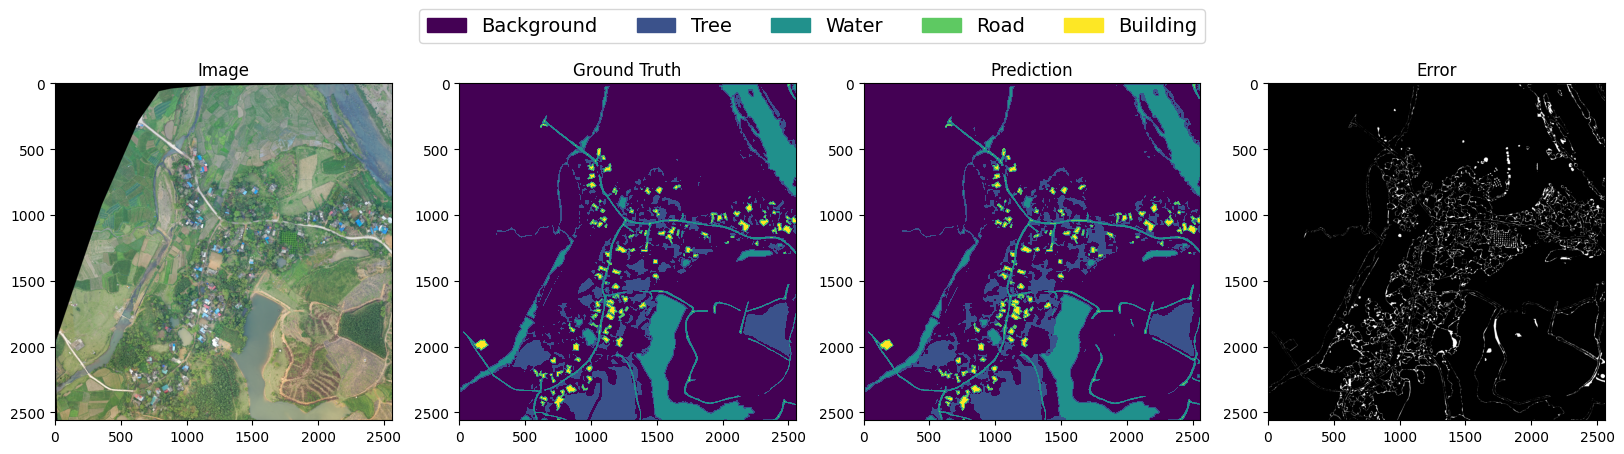

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np

# Use a default Matplotlib colormap (tab10)
cmap = plt.get_cmap(lut=5)

# Define the boundaries for the colormap
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create custom legend patches using colors from the 'tab10' colormap
legend_labels = ['Background', 'Tree', 'Water', 'Road', 'Building']
colors = [cmap(i) for i in range(len(legend_labels))]
legend_handles = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(colors))]

plt.figure(figsize=(20, 5))  # Adjust the figure size to make it suitable for a single row

plt.subplot(141)
plt.title('Image')
plt.imshow(img)
# plt.axis('off')

plt.subplot(142)
plt.title('Ground Truth')
plt.imshow(mask, cmap=cmap, norm=norm)
# plt.axis('off')

plt.subplot(143)
plt.title('Prediction')
plt.imshow(unpatched_prediction, cmap=cmap, norm=norm)
# plt.axis('off')

plt.subplot(144)
plt.title('Error')
error = (mask != unpatched_prediction)
error = error.astype('float32')
plt.imshow(error, cmap='gray')

# Add a legend to the figure
plt.figlegend(handles=legend_handles, loc='upper center', ncol=len(colors), fontsize=14)

plt.show()


In [18]:
print(type(error))

<class 'numpy.ndarray'>


In [19]:
print(unpatched_prediction.shape)

(2560, 2560)


In [20]:
# # Convert the numpy array to a PIL Image
# image = Image.fromarray(unpatched_prediction.astype(np.uint8))

# # Specify the folder and filename
# folder = 'infer_image'
# filename = 'prediction.tif'
# filepath = os.path.join(folder, filename)

# # Save the image
# image.save(filepath)

# print(f'Image saved to {filepath}')

In [21]:
# Assuming unpatched_prediction is already defined
# Define a color map for the pixel values
color_map = {
    0: [0, 0, 0],         # Black for background
    1: [0, 255, 0],       # Green for tree
    2: [0, 0, 255],       # Blue for water
    3: [255, 255, 0],     # Yellow for road
    4: [255, 0, 0]        # Red for building
}

# Get the shape of the unpatched_prediction
height, width = unpatched_prediction.shape

# Create an empty array for the colored image
colored_image = np.zeros((height, width, 3), dtype=np.uint8)

# Apply the color map
for value, color in color_map.items():
    colored_image[unpatched_prediction == value] = color

# Convert the numpy array to a PIL Image
image = Image.fromarray(colored_image)

# Specify the folder and filename
folder = 'infer_image'
filename = 'colored_prediction.jpg'
filepath = os.path.join(folder, filename)

# Ensure the directory exists
os.makedirs(folder, exist_ok=True)

# Save the image
image.save(filepath)

print(f'Image saved to {filepath}')

Image saved to infer_image/colored_prediction.jpg
